In [5]:
#####################################
### Import the relevant libraries ###
#####################################

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from pathlib import Path
import os
import time

***
# **DATA**

In [25]:
PATH = Path("dataset") / "GTSRB"
PATH_TRAIN = PATH / "Training"

def load_dataset():
    train_directories = [PATH_TRAIN / subdir for subdir in os.listdir(PATH_TRAIN) if os.path.isdir(PATH_TRAIN / subdir)]
    #Test data is unlabelled??? -> Just split off training data for testing
    data = [[(cv2.cvtColor(cv2.imread(path / img), cv2.COLOR_BGR2RGB),path.name) for img in os.listdir(path) if img.endswith(".ppm")] for path in train_directories]
    X = [[img[0] for img in row] for row in data]
    Y = [[img[1] for img in row] for row in data]
    #Flatten 2d structure   
    X = [img for row in X for img in row]
    Y = np.array([label for row in Y for label in row])
    return (X,Y)
(X,Y) = load_dataset()

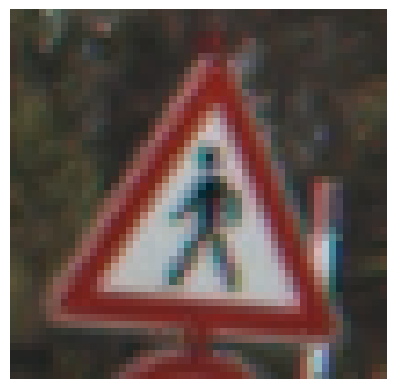

In [29]:
def show_image(img):
    plt.imshow(img)
    plt.axis('off') 
    plt.show()
show_image(X[11])

In [ ]:
#Transform images to same size
t = tf.image.resize(X[0],[64,64])
#Normalise data
normalisation_layer = tf.keras.layers.Rescaling(1./255)

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

['00027', '00013', '00004', '00007', '00030', '00039', '00035', '00005', '00018', '00016', '00020', '00008', '00034', '00009', '00010', '00036', '00026', '00019', '00015', '00040', '00006', '00032', '00012', '00042', '00014', '00021', '00002', '00037', '00003', '00017', '00029', '00024', '00041', '00023', '00022', '00033', '00031', '00025', '00001', '00028', '00011', '00038', '00000']
Found 0 files belonging to 43 classes.


ValueError: No images found in directory dataset/GTSRB/Training. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [ ]:
###############################
### Visualise some examples ###
###############################

def display_some_examples(examples, labels, n_examples):
    plt.figure(figsize=(17,6))

    for i in range(n_examples):
        idx = np.random.randint(0, examples.shape[0] - 1)
        img = examples[idx]
        label = labels[idx]

        plt.subplot(3, 10, i + 1)
        plt.title(str(label))
        plt.imshow(img, cmap='gray')

    plt.tight_layout()
    plt.show()

display_some_examples(X_train, y_train, n_examples=30)

In [ ]:
###############################
### Visualise some features ###
###############################

def plot_random_pixels_from_mnist(examples, labels, num_subplots=30):
    # Flatten the examples dataset (assumed to be in shape (num_samples, 28, 28))
    x_train_flattened = examples.reshape(examples.shape[0], 28 * 28)

    # Randomly select 'num_subplots' features (pixels) from 0 to 783
    random_pixel_indices = np.random.choice(28 * 28, num_subplots, replace=False)
    
    plt.figure(figsize=(14, 8))
    
    for i, pixel_idx in enumerate(random_pixel_indices):
        plt.subplot(5, 6, i + 1)  # Create a 5x6 grid of subplots
        
        # Get the color intensities for the selected pixel across all images
        pixel_values = x_train_flattened[:, pixel_idx]
        
        # Plot the pixel values on the x-axis and the class labels (labels) on the y-axis
        plt.scatter(pixel_values, labels, alpha=0.5, s=1)
        
        plt.title(f'Pixel {pixel_idx}')
        plt.xlabel('Color Intensity (0-255)')
        plt.ylabel('Class Label (0-9)')
        plt.xlim([0, 255])  # Color intensity is between 0 and 255
    
    plt.tight_layout()
    plt.show()

# Example usage assuming x_train and y_train are loaded MNIST dataset arrays
plot_random_pixels_from_mnist(X_train, y_train, num_subplots=30)


***
# **BASE TRAINING**

In [ ]:
##########################
### Set some variables ###
##########################

input_size = 28 * 28
batch_size = 64
epochs = 6
n_classes = 10
epsilon = 0.3
alpha = 0.1
num_iter = 10


In [ ]:
############################
### Pre-process the data ###
############################

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = np.array(X_train).reshape(X_train.shape[0], input_size)
X_test = np.array(X_test).reshape(X_test.shape[0], input_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
########################
### Define the model ###
########################

def get_model(input_size):
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_size,), name='input_features'),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
            tf.keras.layers.Dense(10, activation='linear', kernel_initializer=initializer, name='output_layer')
        ])
    print(model.summary())
    return model

In [ ]:
##########################
### Train a base model ###
##########################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

model_base = get_model(input_size)
model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
model_base.fit(train_dataset, epochs=epochs, validation_data=test_dataset,)

In [ ]:
###############################################################
### Define the precision, recall, F1 and ROC curve function ###
###############################################################

def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(c))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_base, X_test, y_test, n_classes)

In [ ]:
######################################
### Define the PGD attack function ###
######################################

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv

In [ ]:
############################################################################
### Define the function to visualize the original and adversarial images ###
############################################################################

def original_vs_adversarial_images(x_og, y_og, x_adv, y_pred):
    plt.figure(figsize=(17, 4))

    # Counter for how many images to display
    display_count = 0

    for i in range(len(x_og)):
        # Check if the class changes after the attack
        if y_og[i] != y_pred[i]:
            # Original images (reshape from (28, 28, 1) to (28, 28))
            original_image = x_og[i].reshape(28, 28)
            
            # Adversarial images (reshape from (28, 28, 1) to (28, 28))
            adversarial_image = x_adv[i].numpy().reshape(28, 28)

            # Plot original images
            plt.subplot(2, 10, display_count + 1)
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Orig: {y_og[i]}')

            # Plot adversarial images
            plt.subplot(2, 10, display_count + 11)
            plt.imshow(adversarial_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Adv: {y_pred[i]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 10:
                break

    plt.tight_layout()
    plt.show()

In [ ]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample = X_test
y_test_sample = y_test

# Generate adversarial examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
original_vs_adversarial_images(x_test_sample, y_test_sample, x_test_adv, y_pred_adv)

***
# **ADVERSARIAL TRAINING**

In [ ]:
################################################
### Define the adversarial training function ###
################################################

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [ ]:
##################################
### Train an adversarial model ###
##################################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model(input_size)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

In [ ]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_adv, X_test, y_test, n_classes)

In [ ]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample_ADV = X_test
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
original_vs_adversarial_images(x_test_sample_ADV, y_test_sample_ADV, x_test_adv_ADV, y_pred_adv_ADV)